In [1]:
import tensorflow as tf
import librosa
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import librosa.display
from TUtils import get_all_dlc_files
import SongLoader

# check if tensorflow is working correctly
plt.rcParams['figure.figsize'] = [12, 8]
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Downloads/73987/Sabaton_SpartaDellmar_v1_p/dellmarsabatonspartav1.ogg
(2, 5910900)
(2, 128, 11545)
(2, 128, 11545)


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

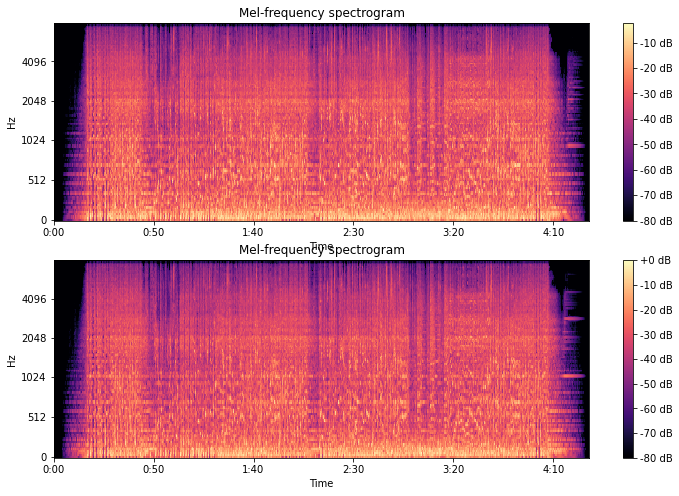

In [17]:
dlc_files = get_all_dlc_files("Downloads")
print((dlc_files[0]["ogg"]))
y, sr = librosa.load(dlc_files[0]["ogg"],mono=False)
print(y.shape)
fig, axs = plt.subplots(2)
S=librosa.feature.melspectrogram(y=y, sr=sr)
print(S.shape)
S_dB = librosa.power_to_db(S, ref=np.max)
print(S_dB.shape)
img = librosa.display.specshow(S_dB[0,:,:], x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=axs[0])
fig.colorbar(img, ax=axs[0], format='%+2.0f dB')
axs[0].set(title='Mel-frequency spectrogram')
img = librosa.display.specshow(S_dB[1,:,:], x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=axs[1])
fig.colorbar(img, ax=axs[1], format='%+2.0f dB')
axs[1].set(title='Mel-frequency spectrogram')

In [11]:
all_dlcs = get_all_dlc_files("Downloads")

for dlc in all_dlcs:
    y, sr = librosa.load(dlc["ogg"],mono=False)
    print(librosa.get_duration(y=y, sr=sr),sr)

268.06802721088434 22050
331.55333333333334 22050
301.24934240362813 22050
258.64136054421766 22050
234.0760090702948 22050
142.0360090702948 22050
204.61469387755102 22050
219.22267573696146 22050
202.3 22050
213.38802721088436 22050
273.4918820861678 22050
299.3853514739229 22050
370.98956916099775 22050
193.19727891156464 22050
218.69569160997733 22050
251.1571882086168 22050
183.39555555555555 22050


(2, 128, 44)


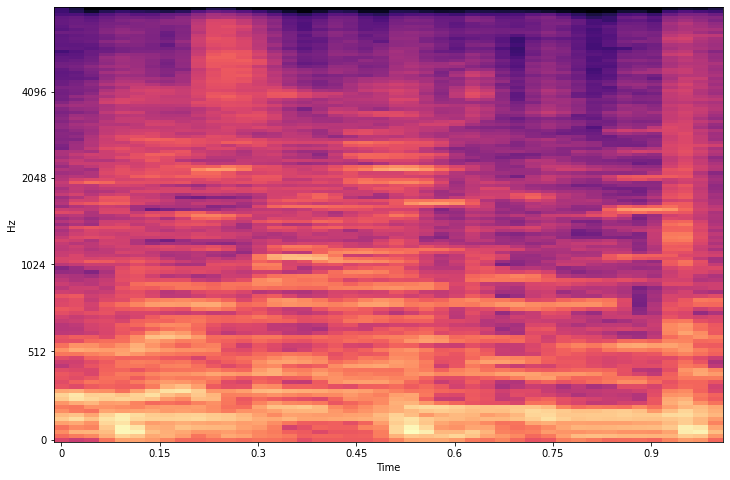

In [3]:
dlcs = get_all_dlc_files("Downloads")
data = SongLoader.load_song(dlcs[4])


S_dB = librosa.power_to_db(data["lead"][1].songSectionSpectrogram, ref=np.max)
print(S_dB.shape)
img = librosa.display.specshow(S_dB[0,:,:], x_axis='time',
                         y_axis='mel', sr=data["sr"],
                         fmax=8000)